In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.display import display, HTML
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#os.listdir('files')

In [3]:
def facetsviz(df):
    jsonstr = df.to_json(orient='records')
    HTML_TEMPLATE = """
            <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
            <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
    html = HTML_TEMPLATE.format(jsonstr=jsonstr)
    return display(HTML(html))

In [4]:
stu = pd.read_csv('files/1.2 Students.csv',parse_dates=['HighSchoolGraduationDate'])
#stu.shape

In [5]:
#percent missing data - drop race2-5, ImmigrantIndicator
stu.isnull().sum() / len(stu)
stu.drop(['Race2','Race3','Race4','Race5','ImmigrantIndicator'],axis=1,inplace=True)

In [6]:
# create hs grad indicator
stu['HS_Grad'] = np.where(stu['HighSchoolGraduationDate'].isnull(),0,1)

In [7]:
#sns.pairplot(stu,vars=['Race1','FoodProgramEligibilityIndicator','Gender'])
#sns.boxplot(data=stu,x='Race1',y='HS_Grad')

In [8]:
# Build basic model with student info only 
#could create stu[age] from school year, but not from grad date - leakage


#create grouped language indicator field (english / spanish / other)
stu['lang'] = np.where((stu['HomeLanguageCode']!= 'English') & (stu['HomeLanguageCode']!= 'Spanish'),
         'Other languages',
         stu['HomeLanguageCode'])

#create target var
target=stu['HS_Grad']

# drop some vars that may or not be useful (just testing basic model)
stu.drop(['SchoolNumber','DistrictNumber','HighSchoolGraduationDate','GradeLevel','HomeLanguageCode','School_Year','SchoolName','BirthDate','nswersguid','HS_Grad'],
         axis=1,inplace=True)

#convert to object types remaining vars, then get dummy vars
# drop_first=False
features = pd.get_dummies(stu.astype('O'))

In [9]:
#split data into train / test -- test data won't be used till very end
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.25,random_state=123)
#lrmodel = LogisticRegression(max_iter=1000)
#lrmodel.fit(X_train,y_train)

# 89%, barely better than the training set target mean of 88%
#print('train set mean HS Grad Rate: ',y_train.mean())
#print('cross val scores: ',cross_val_score(lrmodel,X_train,y_train))

#model score on held out test set
#print('test score: ',lrmodel.score(X_test,y_test))

In [10]:
#put shap plots over model
#explainer = shap.LinearExplainer(lrmodel,X_train, feature_perturbation="interventional")
#shap_values = explainer.shap_values(X_test)

#pass dense verison for plotting
#X_test_array = X_test.to_numpy()

#shap.summary_plot(shap_values, X_test_array, feature_names=features.columns)

### Log Odds Impact of Feature on Output (xgboost)

XGBoost classifier to predict High School Grad (1/0).<br>
The SHAP Values are log odds, and sorted descending by highest impact features.
In this case, all features are 0/1 - which is why we see only blue/red examples in feature value.

Baseline xgboost model, Cross Validation Scores (Accuracy):  [0.89419393 0.89183613 0.89154141 0.89213086 0.88800472]


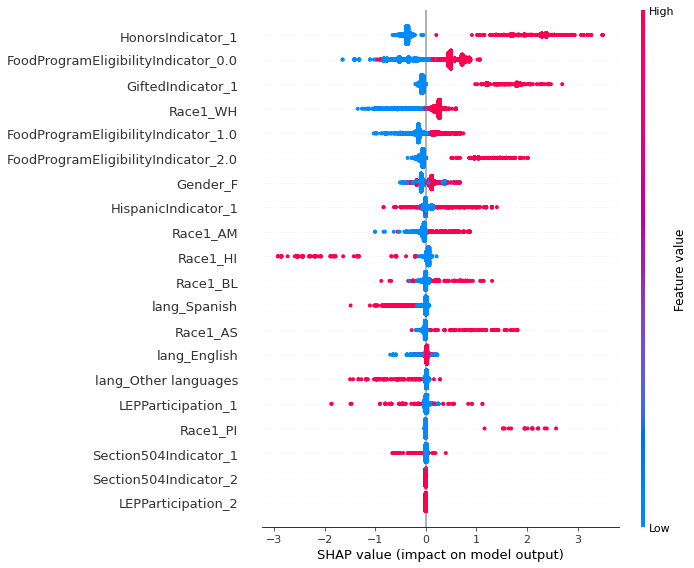

In [11]:
#put shap plots over model
#Log odds shown instead of probabilities
trees = xgboost.XGBClassifier(use_label_encoder =False,eval_metric='logloss').fit(X_train,y_train)
explainer = shap.TreeExplainer(trees)
shap_values = explainer.shap_values(X_test)


#not much diff from logreg
print("Baseline xgboost model, Cross Validation Scores (Accuracy): ",cross_val_score(trees,X_train,y_train))


#pass dense verison for plotting
X_test_array = X_test.to_numpy()

#shap.summary_plot(1/(1+np.exp(-shap_values)), X_test_array, feature_names=features.columns)
shap.summary_plot(shap_values, X_test_array, feature_names=features.columns)

In [12]:
##xs = np.linspace(-4,4,100)
#plt.xlabel("Log odds of grad")
#plt.ylabel("Probability of grad")
#plt.title("How changes in log odds convert to probability of grad")
#plt.plot(xs, 1/(1+np.exp(-xs)))
#plt.show()

### Mean SHAP plot
Represents avg Absolute contribution for each variable

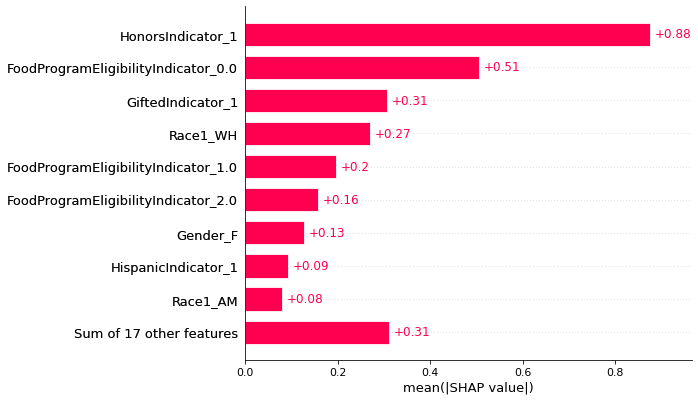

In [13]:
shap_ex = explainer(X_test)
#affect of features on average model output
#shap.plots.waterfall(shap_ex[0])
shap.plots.bar(shap_ex)

### Individual Example Plots 

Can show per example (in this case, first observed row in the test set) which features drive the prediction lower or higher from the base value (2.142 logodds)

In [14]:
shap.initjs()
shap_ex = explainer(X_test)
shap.plots.force(shap_ex[1])

In [15]:
shap_interaction_values = shap.TreeExplainer(trees).shap_interaction_values(X_train.iloc[:,:])

In [16]:
#shap.summary_plot(shap_interaction_values, X_train.iloc[:2000,:])

### Dependence Plots / Interactions

As one example, plot below shows how the contribution of Gender_F to the model is mediated by HonorsIndicator =1.

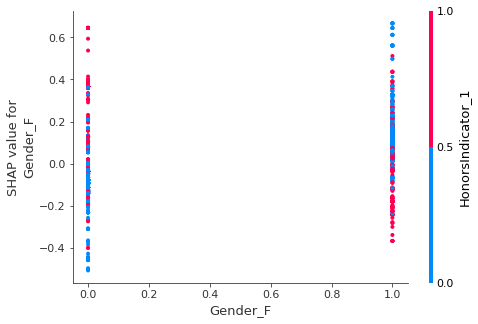

In [17]:
shap.dependence_plot("Gender_F", shap_values,  X_test_array, 
                     feature_names=features.columns,interaction_index="HonorsIndicator_1")

In [18]:
#1.3 should be aggregated somehow - need enrollment codes for grad date
# agg by codes + dates?
#schoolenrl = pd.read_csv('files/1.3 School Enrollment.csv')
#schoolenrl.shape

#stu.merge(schoolenrl,on='nswersguid',suffixes=('','_enrl')).columns
#schoolenrl.head()

#schoolenrl['EnrollmentCode']=schoolenrl['EnrollmentCode'].astype('O')
#schoolenrl['EnrollmentCode'].value_counts()

In [19]:
### 1.4 Grades
#grades = pd.read_csv('files/1.4 Student Grades.csv')
#grades.shape

In [15]:
#grades.isnull().sum()/len(grades)